# Semantic search in business news

<div class="alert alert-block alert-warning">
Replace <code>YOUR_GITHUB_TOKEN</code> in the install script. To get your token follow the instructions in the <a href="../README.md">README.md</a>
</div>

## Boilerplate

### Installation

In [1]:
%pip install  'https://us-central1-data-359211.cloudfunctions.net/github-proxy/superlinked-2.20.0-py3-none-any.whl?token=YOUR_GITHUB_TOKEN'

### Imports and constants

In [2]:
from datetime import datetime, timedelta, timezone

import altair as alt
import pandas as pd

from superlinked.evaluation.charts.recency_plotter import RecencyPlotter
from superlinked.framework.common.dag.period_time import PeriodTime
from superlinked.framework.common.schema.schema import schema
from superlinked.framework.common.schema.schema_object import String, Timestamp
from superlinked.framework.common.schema.id_schema_object import IdField
from superlinked.framework.common.parser.dataframe_parser import DataFrameParser
from superlinked.framework.dsl.executor.in_memory.in_memory_executor import InMemoryExecutor, InMemoryApp
from superlinked.framework.dsl.index.index import Index
from superlinked.framework.dsl.query.param import Param
from superlinked.framework.dsl.query.query import Query
from superlinked.framework.dsl.query.result import Result
from superlinked.framework.dsl.source.in_memory_source import InMemorySource
from superlinked.framework.dsl.space.text_similarity_space import TextSimilaritySpace
from superlinked.framework.dsl.space.recency_space import RecencySpace

alt.renderers.enable("mimetype")
pd.set_option('display.max_colwidth', 200)

In [3]:
MODEL = "sentence-transformers/all-mpnet-base-v2"
YEAR_IN_DAYS = 365
TOP_N = 10
DATASET_URL = "https://storage.googleapis.com/superlinked-notebook-news-dataset/business_news.json"

## Prepare & explore dataset

In [4]:
business_news = pd.read_json(DATASET_URL, convert_dates=True)

In [5]:
# we are going to need an id column
business_news = business_news.reset_index().rename(columns={"index": "id"})
# we need to handle the timestamp being set in milliseconds
business_news["date"] = [date.replace(tzinfo=timezone.utc).timestamp() for date in business_news.date]

In [6]:
# a sneak peak into the data
business_news.head()

,id,link,headline,category,short_description,authors,date
0,162,https://www.huffpost.com/entry/rei-workers-berkeley-store-union_n_6307a5f4e4b0f72c09ded80d,REI Workers At Berkeley Store Vote To Unionize In Another Win For Labor,BUSINESS,They follow in the footsteps of REI workers in New York City who formed a union earlier this year.,Dave Jamieson,1.661386e+09
1,353,https://www.huffpost.com/entry/twitter-elon-musk-trial-october_n_62d7c115e4b000da23f9c7df,Twitter Lawyer Calls Elon Musk 'Committed Enemy' As Judge Sets October Trial,BUSINESS,Delaware Chancery Judge Kathaleen McCormick dealt the world's richest person a setback in ordering a speedy trial on his abandoned deal to buy Twitter.,Marita Vlachou,1.658275e+09
2,632,https://www.huffpost.com/entry/starbucks-leaves-russian-market-shuts-stores_n_628b9804e4b05cfc268f4413,"Starbucks Leaving Russian Market, Shutting 130 Stores",BUSINESS,Starbucks' move follows McDonald's exit from the Russian market last week.,"DEE-ANN DURBIN, AP",1.653264e+09
3,690,https://www.huffpost.com/entry/coinbase-crypto-slumping_n_627c5582e4b0b74b0e7ed621,Crypto Crash Leaves Trading Platform Coinbase Slumped,BUSINESS,Cryptocurrency trading platform Coinbase has lost half its value in the past week.,"Matt Ott, AP",1.652314e+09
4,727,https://www.huffpost.com/entry/us-april-jobs-report-2022_n_627517dfe4b009a811c295ec,"US Added 428,000 Jobs In April Despite Surging Inflation",BUSINESS,"At 3.6%, unemployment nearly reached the lowest level in half a century.","Paul Wiseman, AP",1.651795e+09


### Understand release date distribution

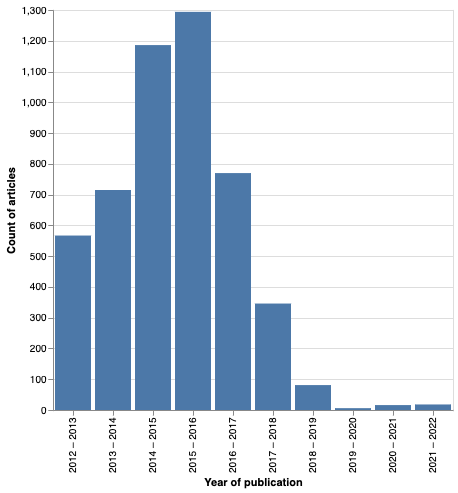

In [7]:
# some quick transformations and an altair histogram
# note that we take a sample to fit into altair's 5000 record limit
years_to_plot: pd.DataFrame = pd.DataFrame(
    {"year_of_publication": [int(datetime.fromtimestamp(ts).year) for ts in business_news["date"]]}).sample(4999)
alt.Chart(years_to_plot).mark_bar().encode(
    alt.X("year_of_publication:N", bin=True, title="Year of publication"),
    y=alt.Y('count()', title="Count of articles"),
).properties(width=400, height=400)

The largest period time should be around 12 years as the oldest article is from 2012.

As most articles are between 2012-2017 therefore 7 years can also make sense to differentiate the relatively scarce recent period.

It can also make sense to give additional weight to more populous time periods - small differences there can be amplified by adding extra weight compared to regions where the data is scarce and differences are larger on average.

## Set up Superlinked

In [8]:
@schema
class NewsSchema:
    description: String
    headline: String
    release_timestamp: Timestamp
    id: IdField

In [9]:
news = NewsSchema()

In [10]:
description_space = TextSimilaritySpace(text=news.description, model=MODEL)
headline_space = TextSimilaritySpace(text=news.headline, model=MODEL)
recency_space = RecencySpace(timestamp=news.release_timestamp, period_time_list=[
    PeriodTime(timedelta(days=7 * YEAR_IN_DAYS), weight=1),
    PeriodTime(timedelta(days=12 * YEAR_IN_DAYS), weight=1)],
    negative_filter=0.0)

In [11]:
news_index = Index(spaces=[description_space, headline_space, recency_space])

In [12]:
query_text_param = Param("query_text")

simple_query = (
    Query(news_index, weights={
        description_space: Param("description_weight"),
        headline_space: Param("headline_weight"),
        recency_space: Param("recency_weight")
    })
    .find(news)
    .similar(description_space.text, query_text_param)
    .similar(headline_space.text, query_text_param)
    .limit(TOP_N)
)

news_query = (
    Query(news_index, weights={
        description_space: Param("description_weight"),
        headline_space: Param("headline_weight"),
        recency_space: Param("recency_weight")
    })
    .find(news)
    .with_vector(news, Param("news_id"))
    .limit(TOP_N)
)

In [13]:
dataframe_parser = DataFrameParser(schema=news, mapping={news.release_timestamp: "date", news.description: "short_description"})

In [14]:
source: InMemorySource = InMemorySource(news, parser=dataframe_parser)
executor: InMemoryExecutor = InMemoryExecutor(sources=[source], indices=[news_index])
app: InMemoryApp = executor.run()

This next one might take a few minutes to run. It is scientifically proven, that watching [this video](https://www.youtube.com/watch?v=1prweT95Mo0&ab_channel=YoYoMaVEVO) will make you feel better and the following cell would also probably run meanwhile. If not, you can still do something quick while smiling.

In [15]:
source.put([business_news])

## Understanding recency

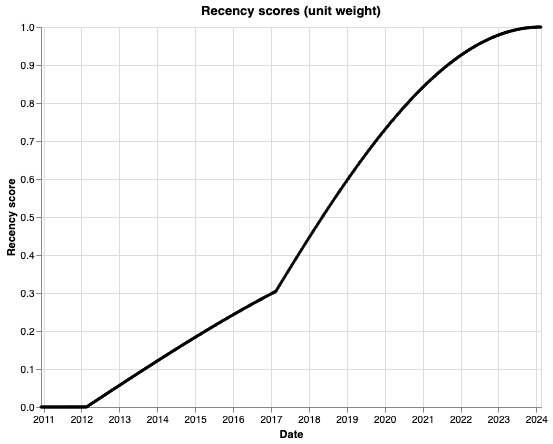

In [16]:
recency_plotter = RecencyPlotter(recency_space)
recency_plotter.plot_recency_curve()

## Queries

In [17]:
# quick helper to present the results in a notebook
def present_result(result: Result, cols_to_keep: list[str] = ["description", "headline", "release_date", "id"]) -> pd.DataFrame:
    # parse result to dataframe
    df: pd.DataFrame = pd.DataFrame([entry.stored_object for entry in result.entries])
    # transform timestamp back to release year. Ts is in milliseconds originally hence the division
    df["release_date"] = [datetime.fromtimestamp(timestamp, tz=timezone.utc).date() for timestamp in df["release_timestamp"]]
    return df[cols_to_keep]

Let's search for one of the biggest acquisitions of the last decade! We are going to set recency's weight to 0 as it does not matter at this point.

In [18]:
result = app.query(
    simple_query,
    query_text = "Microsoft acquires LinkedIn",
    description_weight=1,
    headline_weight=1,
    recency_weight=0
)

present_result(result)

,description,headline,release_date,id
0,"(Reuters) - Microsoft Corp agreed to buy LinkedIn Corp for $26.2 billion in cash, the companies said in",Microsoft Agrees To Acquire LinkedIn For $26.2 Billion,2016-06-13,64890
1,"Without question, LinkedIn has forever altered the business landscape -- both digitally and in the physical world. Nowadays, so much of what we call business or career development is carried out r...",The LinkedIn of Things,2015-01-06,110756
2,LinkedIn works very well for the millions of people who make the effort to understand how to leverage it effectively. And those people are very likely not spending more than fifteen a minutes a da...,The 7 LinkedIn Job Search Mistakes That Might Be Costing You a Job,2014-06-26,127772
3,"Although under-used by average LinkedIn members, LinkedIn Groups can be critical to a successful job search because they enable you to communicate directly with recruiters. And vice versa.",Get LinkedIn to Recruiters for Your Job Search,2014-07-07,126794
4,NEW YORK (AP) — Anthem is buying rival Cigna for $48 billion in a deal that would create the nation's largest health insurer,MEGA-MERGER: Anthem To Buy Cigna For $54 Billion,2015-07-24,93451
5,"Facebook and the billionaire Mark Zuckerberg has joined the establishment. It has become another corporate giant which cheated us, luring on a concept of global friendship which has turned out to ...",Facebook Is No Longer Cool,2012-02-05,208810
6,The struggling social network is looking for a buyer.,Twitter Is Reportedly In Sales Talks With Google And Salesforce,2016-09-23,55880
7,The company's value has soared in the last five years and it has more users than Twitter.,Snapchat Is Reportedly Planning A $25 Billion IPO,2016-10-06,54727
8,"If failed corporate mergers teach us anything about business, it's that bigger is not always better. Yep, with a 70 to 90",9 Mergers That Epically Failed,2013-02-23,173078
9,"Another day, another merger. Telephone companies, drug companies, drugstores, airlines, hospitals, retail stores and beer. Why?",The Great Remix: Why Mergers Are Booming,2015-11-01,84610


The first result is about the deal, others are related to some aspect of the query. Let's try upweighting recency to see a recent big acquisition jump to the second place.

In [19]:
result = app.query(
    simple_query,
    query_text = "Microsoft acquires LinkedIn",
    description_weight=1,
    headline_weight=1,
    recency_weight=1,
)

present_result(result)

,description,headline,release_date,id
0,"(Reuters) - Microsoft Corp agreed to buy LinkedIn Corp for $26.2 billion in cash, the companies said in",Microsoft Agrees To Acquire LinkedIn For $26.2 Billion,2016-06-13,64890
1,"“My offer is my best and final offer and if it is not accepted, I would need to reconsider my position as a shareholder,” Musk said in a filing.",Elon Musk Offers To Buy 100% Of Twitter,2022-04-14,849
2,Starbucks' move follows McDonald's exit from the Russian market last week.,"Starbucks Leaving Russian Market, Shutting 130 Stores",2022-05-23,632
3,"Without question, LinkedIn has forever altered the business landscape -- both digitally and in the physical world. Nowadays, so much of what we call business or career development is carried out r...",The LinkedIn of Things,2015-01-06,110756
4,Delaware Chancery Judge Kathaleen McCormick dealt the world's richest person a setback in ordering a speedy trial on his abandoned deal to buy Twitter.,Twitter Lawyer Calls Elon Musk 'Committed Enemy' As Judge Sets October Trial,2022-07-20,353
5,The decision comes as surging oil prices have been rattling global markets and after Ukraine’s foreign minister criticized Shell for continuing to buy Russian oil.,"Shell Says It Will Stop Buying Russian Oil, Natural Gas",2022-03-08,1054
6,That makes seven Starbucks stores that have voted to unionize in a matter of months.,Starbucks Workers In Seattle Vote To Form Union,2022-03-23,967
7,Recent statements by CEO Howard Schultz offer a glimpse of some of the hardball tactics that might lay ahead.,"For The Starbucks Union Campaign, A Bruising Contract Fight Is Just Beginning",2022-04-16,837
8,The store in Arizona joins two in New York as the only corporate Starbucks stores with a union.,Another Starbucks Store Votes To Unionize,2022-02-25,1117
9,"Android creator Andy Rubin, accused of sexual harassment, was given a severance package worth $240 million, according to the lawsuit.",Google's Alphabet Settles With Shareholders Over Payoffs To Execs Accused Of Harassment,2020-09-26,4025


Subsequently we can also search with the news article about Elon Musk offering to buy Twitter. As the dataset is quite biased towards old articles, what we get back is news about either Elon Musk or Twitter.

In [20]:
result = app.query(
    news_query,
    description_weight=1,
    headline_weight=1,
    recency_weight=0,
    news_id="849",
)

present_result(result)

,description,headline,release_date,id
0,"“My offer is my best and final offer and if it is not accepted, I would need to reconsider my position as a shareholder,” Musk said in a filing.",Elon Musk Offers To Buy 100% Of Twitter,2022-04-14,849
1,Don't bet against Musk.,Why Elon Musk’s Plan To Merge Tesla With SolarCity Will Probably Work,2016-08-16,59220
2,Elon Musk's empire is consolidating.,Tesla Is Buying Sister Company SolarCity For $2.6 Billion,2016-08-01,60483
3,The U.S. Securities and Exchange Commission filed a motion asking for the Tesla CEO to show why he shouldn't be held in contempt.,SEC Says Elon Musk Violated Fraud Settlement With Tweet,2019-02-26,7191
4,The billionaire wants to marry Tesla and SolarCity. But he says SpaceX should remain a bachelor.,The One Company Elon Musk Wants To Keep Independent,2016-08-04,60237
5,"The interim CEO purchased 31,000 shares Monday.","Jack Dorsey Bought A Bunch Of Twitter Shares, And It's Working Out Great",2015-08-10,91958
6,"Tesla's CEO says hiring self-driving engineers is ""a super high priority.""",Elon Musk Just Dropped Another Hint That Tesla May Take On Uber,2015-11-20,82841
7,Time Warner rejected an $80 billion offer from a different company in 2014.,"AT&T Agrees To Buy Time Warner, In Principle",2016-10-21,53309
8,"It's an Elon Musk world, and we're just living in it. Before we bow down to a seemingly fearless and altruistic pioneer of electric vehicles and libertarianism, it's important to point out the ong...",Elon Musk Is Even Smarter Than We Thought,2014-06-14,128870
9,"This could all be part of the secret sauce known as the ""Musk Doctrine.""","Wall Street Doesn’t Believe Elon Musk Can Produce 500,000 Cars By 2018",2016-05-09,67933


That we can start biasing towards recency, navigating the tradeoff of letting less connected but recent news into the mix. 

In [21]:
result = app.query(
    news_query,
    description_weight=1,
    headline_weight=1,
    recency_weight=1,
    news_id="849",
)

present_result(result)

,description,headline,release_date,id
0,"“My offer is my best and final offer and if it is not accepted, I would need to reconsider my position as a shareholder,” Musk said in a filing.",Elon Musk Offers To Buy 100% Of Twitter,2022-04-14,849
1,The U.S. Securities and Exchange Commission filed a motion asking for the Tesla CEO to show why he shouldn't be held in contempt.,SEC Says Elon Musk Violated Fraud Settlement With Tweet,2019-02-26,7191
2,Delaware Chancery Judge Kathaleen McCormick dealt the world's richest person a setback in ordering a speedy trial on his abandoned deal to buy Twitter.,Twitter Lawyer Calls Elon Musk 'Committed Enemy' As Judge Sets October Trial,2022-07-20,353
3,Recent statements by CEO Howard Schultz offer a glimpse of some of the hardball tactics that might lay ahead.,"For The Starbucks Union Campaign, A Bruising Contract Fight Is Just Beginning",2022-04-16,837
4,"Android creator Andy Rubin, accused of sexual harassment, was given a severance package worth $240 million, according to the lawsuit.",Google's Alphabet Settles With Shareholders Over Payoffs To Execs Accused Of Harassment,2020-09-26,4025
5,The assets were the subject of recent talks between Fox and Walt Disney Co.,"Verizon, Comcast Approach 21st Century Fox About Acquiring Assets",2017-11-16,20285
6,The decision comes as surging oil prices have been rattling global markets and after Ukraine’s foreign minister criticized Shell for continuing to buy Russian oil.,"Shell Says It Will Stop Buying Russian Oil, Natural Gas",2022-03-08,1054
7,Tesla CEO issues a dire warning.,Elon Musk Predicts The Cause Of World War III (And It's Not Donald Trump),2017-09-05,25949
8,Don't bet against Musk.,Why Elon Musk’s Plan To Merge Tesla With SolarCity Will Probably Work,2016-08-16,59220
9,Starbucks' move follows McDonald's exit from the Russian market last week.,"Starbucks Leaving Russian Market, Shutting 130 Stores",2022-05-23,632
